# **Import Required Libraries**

In [ ]:
# Basic libraries
import pandas as pd
import numpy as np

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# NLP and text processing
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

# ML preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ML models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Model evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# **Loading the Dataset**

In [ ]:
# Load dataset
df = pd.read_csv("ecommerce_furniture_dataset_2024.csv")
df.head()

,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping


# **Data Cleaning and Feature Engineering**

In [ ]:
# Convert price columns from string to numeric
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['originalPrice'] = df['originalPrice'].replace('[\$,]', '', regex=True)
df['originalPrice'] = pd.to_numeric(df['originalPrice'], errors='coerce')

# Handle missing values in tagText
df['tagText'] = df['tagText'].astype(str).fillna('Unknown')

# Impute missing originalPrice using shipping cost from tagText
def estimate_original_price(row):
    if pd.isna(row['originalPrice']):
        if row['tagText'].startswith('+Shipping:'):
            try:
                ship_cost = float(row['tagText'].split('$')[1].replace(',', ''))
                return row['price'] + ship_cost
            except:
                return np.nan
        else:
            return np.nan
    else:
        return row['originalPrice']

df['originalPrice'] = df.apply(estimate_original_price, axis=1)

# Discount rate feature
df['discount_rate'] = ((df['originalPrice'] - df['price']) / df['originalPrice']) * 100

# Price bucket feature
df['price_bucket'] = pd.cut(df['price'], bins=[0, 500, 1000, 2000, df['price'].max()], labels=['Low', 'Mid', 'High', 'Luxury'])

# Simplify tagText categories
df['tagText'] = df['tagText'].apply(lambda x: x if x in ['Free shipping', '+Shipping: $5.09'] else 'Others')

# **Exploratory Data Analysis (EDA)**

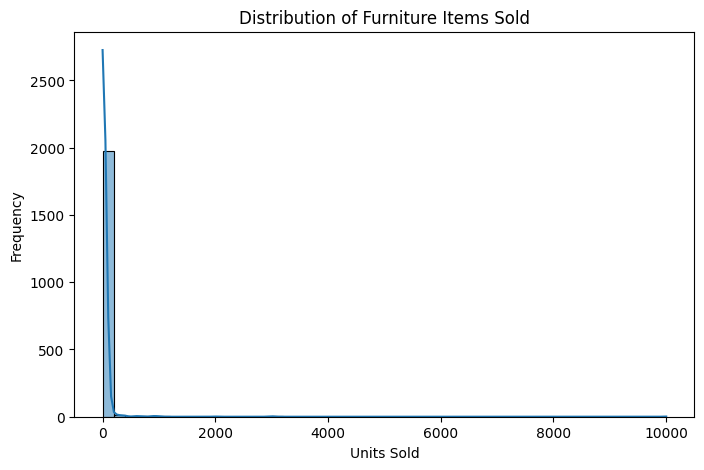

In [ ]:
# Distribution of target variable 'sold'
plt.figure(figsize=(8,5))
sns.histplot(df['sold'], bins=50, kde=True)
plt.title("Distribution of Furniture Items Sold")
plt.xlabel("Units Sold")
plt.ylabel("Frequency")
plt.show()

**Analyze Price vs Sold (Scatter)**

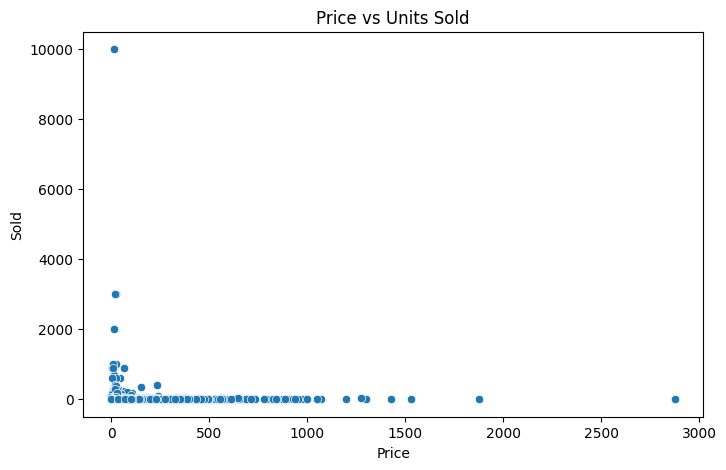

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='price', y='sold', data=df)
plt.title("Price vs Units Sold")
plt.xlabel("Price")
plt.ylabel("Sold")
plt.show()

**Boxplot of Price by Shipping Type**

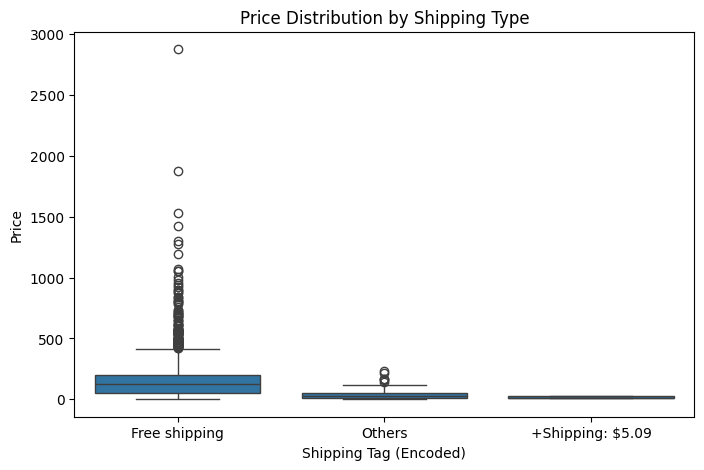

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='tagText', y='price', data=df)
plt.title("Price Distribution by Shipping Type")
plt.xlabel("Shipping Tag (Encoded)")
plt.ylabel("Price")
plt.show()

**Discount Impact on Sales**

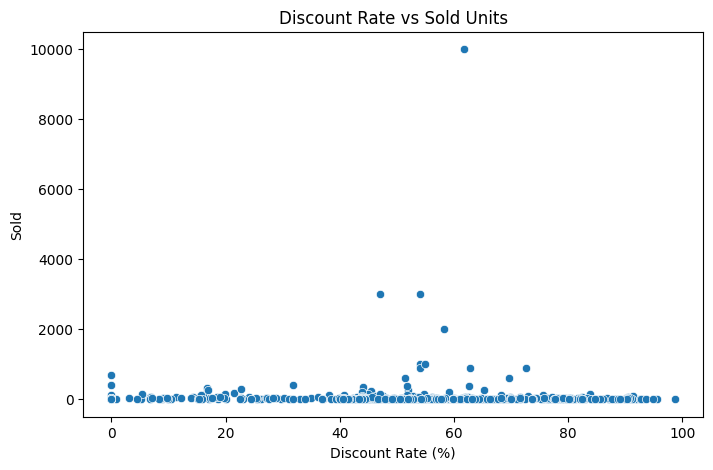

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='discount_rate', y='sold', data=df)
plt.title("Discount Rate vs Sold Units")
plt.xlabel("Discount Rate (%)")
plt.ylabel("Sold")
plt.show()

# **Text Feature Engineering**

In [ ]:
# TF-IDF Vectorization on productTitle
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
title_tfidf = tfidf.fit_transform(df['productTitle'])

# Convert sparse matrix to DataFrame
tfidf_df = pd.DataFrame(title_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Add TF-IDF features to main DataFrame
df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

# Sentiment Analysis from productTitle
df['title_sentiment'] = df['productTitle'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Flag keywords in product titles
df['has_modern'] = df['productTitle'].str.contains('modern', case=False).astype(int)
df['has_wood'] = df['productTitle'].str.contains('wood', case=False).astype(int)
df['has_compact'] = df['productTitle'].str.contains('compact', case=False).astype(int)

# Drop the original text column
df.drop('productTitle', axis=1, inplace=True)

**Correlation Heatmap**

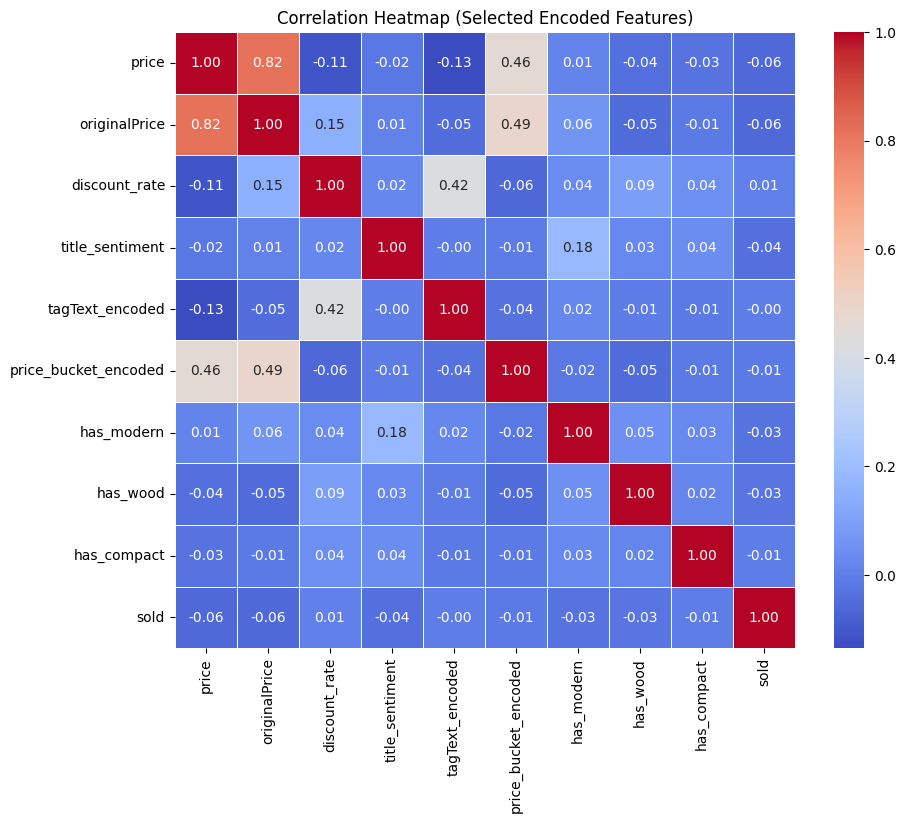

In [ ]:
# Encode tagText and price_bucket before plotting
from sklearn.preprocessing import LabelEncoder

# Check if already encoded to avoid re-encoding
if 'tagText_encoded' not in df.columns:
    le_tag = LabelEncoder()
    df['tagText_encoded'] = le_tag.fit_transform(df['tagText'])

if 'price_bucket_encoded' not in df.columns:
    le_bucket = LabelEncoder()
    df['price_bucket_encoded'] = le_bucket.fit_transform(df['price_bucket'].astype(str))

# Select relevant numerical columns
selected_corr_cols = ['price','originalPrice','discount_rate','title_sentiment','tagText_encoded','price_bucket_encoded','has_modern','has_wood','has_compact','sold']

# Plot the cleaned heatmap
plt.figure(figsize=(10,8))
corr = df[selected_corr_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Selected Encoded Features)")
plt.show()

# **Encoding Categorical Features and Final Dataset Preparation**

In [ ]:
# Encode tagText and price_bucket
le = LabelEncoder()
df['tagText'] = le.fit_transform(df['tagText'])
df['price_bucket'] = le.fit_transform(df['price_bucket'].astype(str))

# Drop rows with missing values after all processing
df.dropna(inplace=True)

# Separate features and target
X = df.drop('sold', axis=1)
y = df['sold']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Model Training and Evaluation**

In [ ]:
# Store results in a list of dictionaries
results = []

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results.append({
        'Model': name,
        'RMSE': round(rmse, 2),
        'R² Score': round(r2, 4)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='R² Score', ascending=False).reset_index(drop=True)

# Display the table
print("📊 Model Performance Comparison:")
print()
print()
display(results_df.style.set_table_attributes("style='display:inline'").set_caption("Model Evaluation Results"))

📊 Model Performance Comparison:




,Model,RMSE,R² Score
0,Random Forest,194.590000,0.526800
1,Gradient Boosting,200.640000,0.496900
2,Ridge Regression,258.380000,0.165700
3,XGBoost,264.770000,0.123900
4,Linear Regression,289.050000,-0.044200


# **Cross-Validation**

🔁 Cross-Validation R² Scores:




,Fold,R² Score
0,Fold 1,0.262435
1,Fold 2,0.056167
2,Fold 3,-5.053968
3,Fold 4,0.189303
4,Fold 5,-5.558108
5,Average,-2.020834


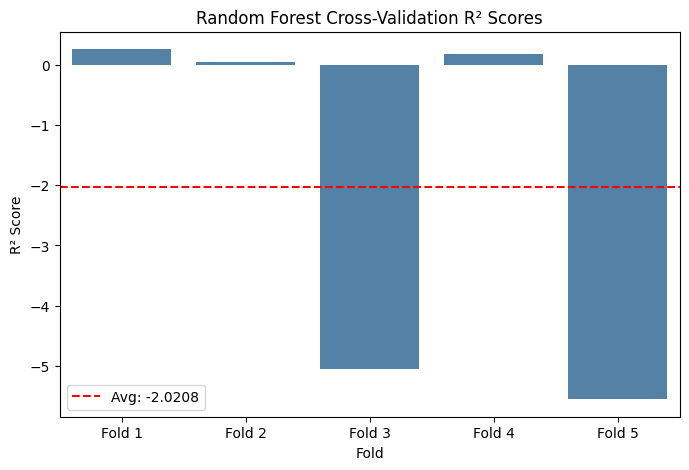

In [ ]:
# Cross-validation for best performing model (e.g., Random Forest)
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(models['Random Forest'], X, y, cv=5, scoring='r2')
avg_score = np.mean(cv_scores)

# Tabular output
cv_df = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(cv_scores))],
    'R² Score': cv_scores
})
cv_df.loc[len(cv_df.index)] = ['Average', avg_score]

# Display table
print("🔁 Cross-Validation R² Scores:")
print()
print()
display(cv_df.style.set_table_attributes("style='display:inline'").set_caption("Random Forest CV Scores"))

# Optional: visualize as barplot
plt.figure(figsize=(8,5))
sns.barplot(x='Fold', y='R² Score', data=cv_df[:-1], color='steelblue')
plt.axhline(avg_score, color='red', linestyle='--', label=f'Avg: {avg_score:.4f}')
plt.title("Random Forest Cross-Validation R² Scores")
plt.legend()
plt.show()

# **Model Explainability with SHAP**

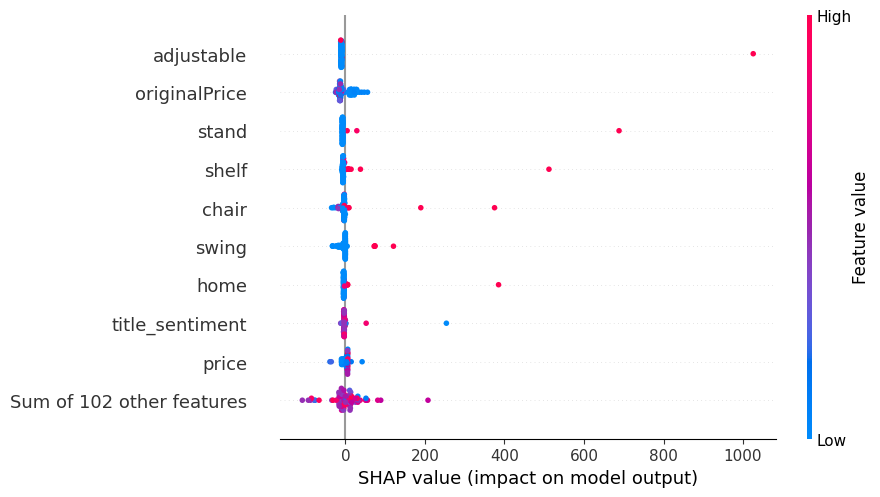

In [ ]:
!pip install shap
import shap
# Use a smaller sample for performance
X_sample = X_train.sample(100, random_state=42)

# Create SHAP explainer
explainer = shap.Explainer(models['Random Forest'], X_sample)

# Compute SHAP values
shap_values = explainer(X_sample)

# Summary plot (global importance)
shap.plots.beeswarm(shap_values)

**Feature Importance (Bar)**

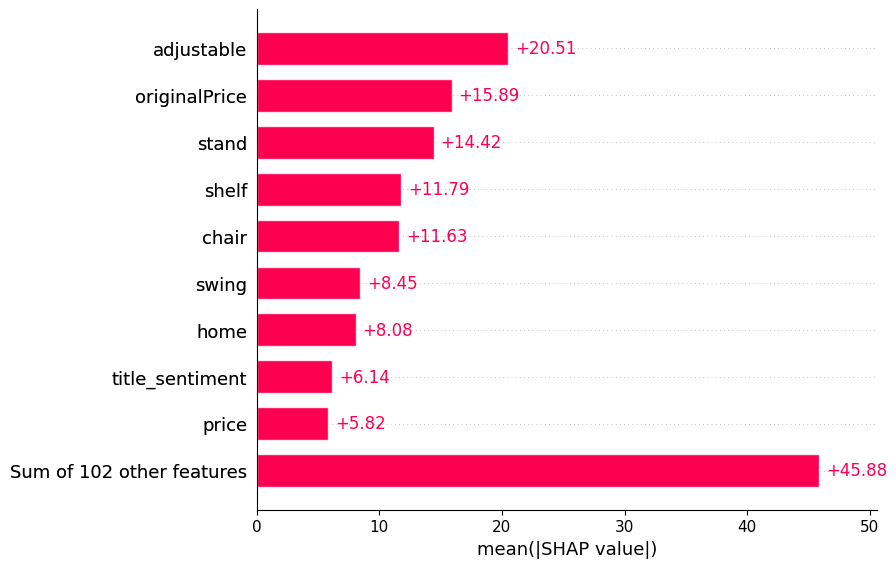

In [ ]:
# Bar chart for feature importance
shap.plots.bar(shap_values)

**Local Explanation for One Prediction**

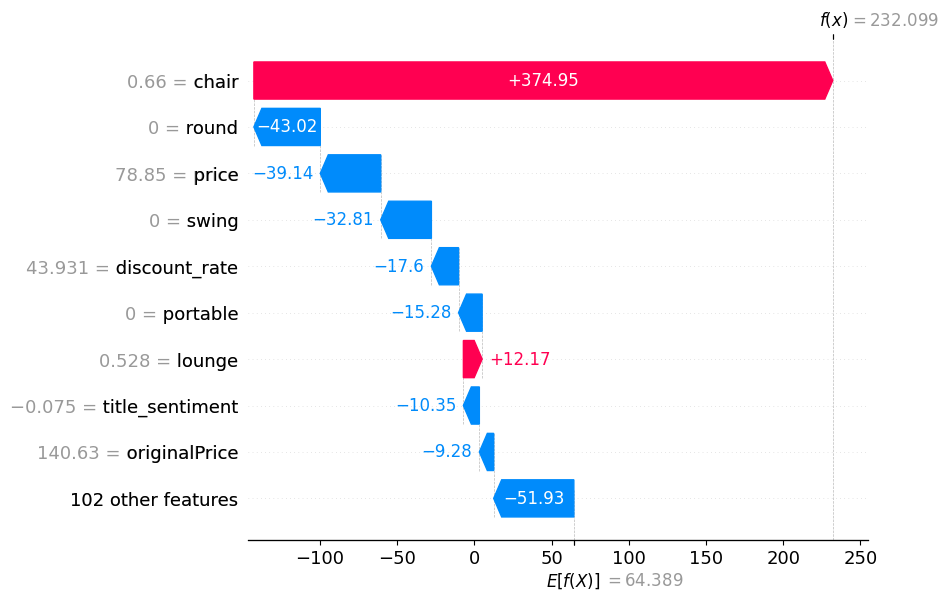

In [ ]:
# Explain prediction for a single sample
shap.plots.waterfall(shap_values[0])

# **Export Cleaned Data to CSV**

In [ ]:
# Export the cleaned, feature-rich dataset

df.to_csv("furniture_data_final.csv", index=False)
from google.colab import files
files.download("furniture_data_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>